In [1]:
import numpy as np
from skfem import *
from skfem.supermeshing import intersect, elementwise_quadrature
from skfem.models.elasticity import (linear_elasticity, lame_parameters,
                                     linear_stress)
from skfem.helpers import dot, sym_grad, jump, mul
from skfem.io.json import from_file

from pathlib import Path
import pandas as pd 
import json 
import matplotlib.pyplot as plt 
from skfem.mesh.mesh  import Mesh
from skfem.visuals.matplotlib import plot, draw
from meshio.stl import _stl
import stl
from stl import mesh

import skfem as fem 
from skfem.helpers import dot, grad 


In [2]:
young_modulus = 1000
poisson_ratio = 0.7

alpha = 1000


weakform = linear_elasticity(*lame_parameters(young_modulus, poisson_ratio))
C = linear_stress(*lame_parameters(young_modulus, poisson_ratio))




@fem.BilinearForm
def a(u,v,_):
    return dot(grad(u),grad(v))




@fem.LinearForm
def L(v,w):
    x, y = w.x
    f = np.sin(np.pi*x)*np.cos(np.pi*y)
    return f*v





<skfem CellBasis(MeshTri1, ElementTriP1) object>
  Number of elements: 1
  Number of DOFs: 3
  Size: 216 B
<skfem MeshTri1 object>
  Number of elements: 1
  Number of vertices: 3
  Number of nodes: 3
  Named subdomains [# elements]: domain [0]
  Named boundaries [# facets]: contact [1], dirichlet [0]
<skfem DofsView(MeshTri1, ElementTriP1) object>
  Number of nodal DOFs: 3 ['u']
[0. 0. 0.]


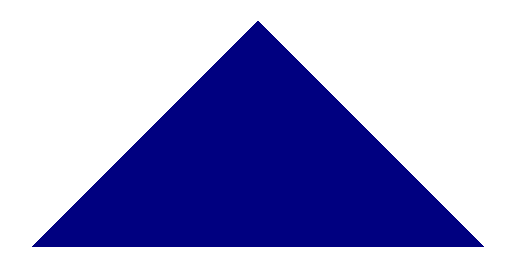

In [6]:
#mesh_file = Path('test_mesh.json')
mesh_file = Path('test_mesh.json ')
m1 = from_file(mesh_file)




e1 = fem.ElementTriP1()

base = fem.Basis(m1, e1)

D = base.get_dofs()

l = L.assemble(base)

A = a.assemble(base)

x = fem.solve(*fem.condense(A, l, D=D))

plot(m1, x)
print(base)

print(m1)
print(D)
print(x)

<skfem FacetBasis(MeshTri1, ElementVector) object>
  Number of elements: 12
  Number of DOFs: 24
  Size: 6912 B
<skfem InteriorFacetBasis(MeshTri1, ElementVector) object>
  Number of elements: 9
  Number of DOFs: 24
  Size: 5184 B
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


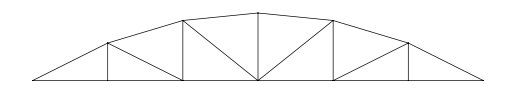

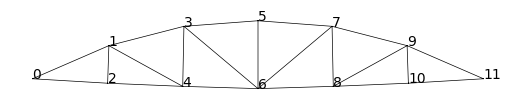

In [77]:
from skfem import *
from skfem.helpers import *
import numpy as np

m = MeshTri(np.array([[0, 0],
                      [10, 5],
                      [10, 0],
                      [20, 8],
                      [20, 0],
                      [30, 9],
                      [30, 0],
                      [40, 8],
                      [40, 0],
                      [50, 5],
                      [50, 0],
                      [60, 0]]).T,
            np.array([[7, 8, 9],
                      [9, 10, 11],
                      [8, 9, 10],
                      [1, 3, 4],
                      [0, 1, 2],
                      [3, 5, 6],
                      [5, 6, 7],
                      [3, 4, 6],
                      [6, 7, 8],
                      [1, 2, 4]]).T)

draw(m)

fbasis = FacetBasis(m, ElementVector(ElementTriP1()))
ifbasis = InteriorFacetBasis(m, ElementVector(ElementTriP1()), side=0)


print(fbasis)
print(ifbasis)

@BilinearForm
def bilinf(u, v, w):
    t = np.array([-w.n[1], w.n[0]])
    ut = ddot(grad(u), prod(t, t))
    vt = ddot(grad(v), prod(t, t))
    return ut * vt


A = asm(bilinf, [ifbasis, fbasis])
f = ifbasis.zeros()

print(f)
f[ifbasis.get_dofs(nodes=(30, 0)).all('u^2')] = -1e-2

D1 = ifbasis.get_dofs(nodes=(0, 0)).all()
D2 = ifbasis.get_dofs(nodes=(60, 0)).all()
D = np.concatenate((D1, D2))

x = solve(*condense(A, f, D=D))
m.translated(x[fbasis.nodal_dofs]).draw(node_numbering=True).show()

@BilinearForm
def bilinf(u, v, w):
    t = np.array([-w.n[1], w.n[0]])
    ut = ddot(grad(u), prod(t, t))
    vt = ddot(grad(v), prod(t, t))
    return ut * vt

Wir benutzen die Biliniear Form mit der Gleichung 

$$u* vt$$
mit $$u_t= \Delta(u)\cdot(t\otimes t)$$
$$v_t = \Delta(v)\cdot (t \otimes t)$$

u ist die Verschiebung in x-Richtung und v ist die Verschiebung in y-Richtung 


Initializing InteriorFacetBasis(MeshTri1, ElementVector) with no facets.


<skfem FacetBasis(MeshTri1, ElementVector) object>
  Number of elements: 3
  Number of DOFs: 6
  Size: 1728 B
<skfem InteriorFacetBasis(MeshTri1, ElementVector) object>
  Number of elements: 0
  Number of DOFs: 6
  Size: 0 B


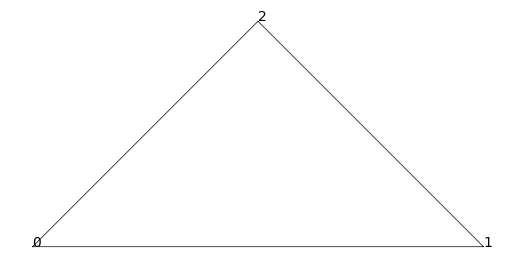

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [78]:
# m2 = np.array([[0, 0],
#                 [10, 5],
#                 [10, 0],
#                 [20, 8],
#                       [20, 0],
#                       [30, 9],
#                       [30, 0],
#                       [40, 8],
#                       [40, 0],
#                       [50, 5],
#                       [50, 0],
#                       [60, 0]]).T

m2 = MeshTri(np.array([[0,0],[1,0],[0.5,0.5]]).T,
             np.array([[0,1,2]]).T)

fbasis = FacetBasis(m2, ElementVector(ElementTriP1()))
ifbasis = InteriorFacetBasis(m2, ElementVector(ElementTriP1()), side = 0)

print(fbasis)
print(ifbasis)
@BilinearForm
def bilinf(u, v, w):
    t = np.array([-w.n[1], w.n[0]])
    ut = ddot(grad(u), prod(t, t))
    vt = ddot(grad(v), prod(t, t))
    return ut * vt

A = asm(bilinf, fbasis)
# f = ifbasis.zeros()
# f[ifbasis.get_dofs(nodes=(30,0)).all('u^2')] = -1e-2

# D1 = ifbasis.get_dofs(nodes=(0,0)).all()
# D2 = ifbasis.get_dofs(nodes=(60,0)).all()
# D = np.concatenate((D1,D2))
D = fbasis.get_dofs(elements = (0)).flatten()

x = solve(*condense(A, f, D=D))
m2.translated(x[fbasis.nodal_dofs]).draw(node_numbering=True).show()

D
